Autor: Natalia Kiełbasa

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore") # żeby wyniki zwracane w zadaniu nie miały w sobie warningów dla lepszej czytelności

## Opis projektu (analizy):

1. Dwa rożne punkty startowe: x0=(-1.5, 1.5), x0=(-1.5, -1.5), 0=(1.5, 1.5), x0=(1.5, -1.5),
2. Dwa (mogą być nawet 3-4) learning_rate
3. Robimy powyższe dla jednego małego step_size, np. 1000, 1500, 500.
4. Potem powtarzamy przy zadanych (jednych) parametrach (wybranych przez Was) analizę dla większego step_size. Step zwiększamy o 1000, 2000, 3000, 4000… można zrobić iteracyjnie dla kilku kolejnych większych step_size, albo zwyczajnie minimalnie to dla wybranego jednego większego step_size. Raczej nie warto wychodzić ponad wartość 12000.
5. Analizę proszę wykonać dla wybranych minimum 3 metod, idealnie 4, np. jedno z (GD/SGD), Momentum, Adam i Muon.

Link do dwóch plików:
- Plik pythonowy, jego należy wykonać (python demonstration_optimziers_many.py): https://ujchmura-my.sharepoint.com/:u:/g/personal/piotr_kuterba_uj_edu_pl/IQAvNWcttd8hR7jSBF_c0zCyARxi1sgUBoi5n8FL9XtmexM?e=og8Rgc
- W tym pliku mamy prawie ten sam kod, tylko w wersji pod jupyter-notebook, dodałem dwie przykładowej analizy/porównania jakby ktoś nie wyłapał na zajęciach:
https://ujchmura-my.sharepoint.com/:u:/g/personal/piotr_kuterba_uj_edu_pl/IQDjlb-C7wUcQ6et33XTWMwNAYOXCwIjfnkTqtxVbvvf2kQ?e=UW8L1f

In [38]:
# Funkcje zdefiniowane na zajęciach

# ----------------------------
# Rosenbrock function + grad
# ----------------------------
def rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    return (a - X)**2 + b*(Y - X**2)**2

def grad_rosenbrock(x, a=1.0, b=100.0):
    X, Y = x[0], x[1]
    dX = -2*(a - X) - 4*b*X*(Y - X**2)
    dY =  2*b*(Y - X**2)
    return np.array([dX, dY], dtype=float)

# ----------------------------
# Optimizers
# ----------------------------
def optimize(optimizer, 
             x0, 
             steps=8000, 
             lr=1e-3, 
             seed=0,
             noise_std=0.0,          # only for "SGD"-style
             beta=0.9,               # momentum / nesterov
             beta1=0.9, beta2=0.999, # adam
             rms_beta=0.99,          # rmsprop
             eps=1e-8,
             weight_decay=0.0):      # for AdamW (optional)
    rng = np.random.default_rng(seed)
    x = np.array(x0, dtype=float)

    v_mom = np.zeros_like(x)  # momentum velocity
    m = np.zeros_like(x)      # Adam first moment
    v = np.zeros_like(x)      # Adam second moment
    s = np.zeros_like(x)      # RMSProp second moment
    v_muon = np.zeros_like(x)  # Muon block momentum

    for t in range(1, steps + 1):
        # Choose gradient evaluation point (for Nesterov)
        if optimizer == "Nesterov":
            g = grad_rosenbrock(x - lr * beta * v_mom)
        else:
            g = grad_rosenbrock(x)

        # Optional "SGD noise" to imitate minibatch stochasticity
        if optimizer in ["SGD", "Momentum", "Nesterov"] and noise_std > 0:
            g = g + rng.normal(0.0, noise_std, size=2)

        if optimizer in ["GD", "SGD"]:
            x = x - lr * g

        elif optimizer == "Momentum":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "Nesterov":
            v_mom = beta * v_mom + (1 - beta) * g
            x = x - lr * v_mom

        elif optimizer == "RMSProp":
            s = rms_beta * s + (1 - rms_beta) * (g * g)
            x = x - lr * g / (np.sqrt(s) + eps)

        elif optimizer == "Adam":
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        elif optimizer == "AdamW":
            # decoupled weight decay (simple demonstration)
            # (weight decay isn't super meaningful here, but included for completeness)
            m = beta1 * m + (1 - beta1) * g
            v = beta2 * v + (1 - beta2) * (g * g)
            m_hat = m / (1 - beta1**t)
            v_hat = v / (1 - beta2**t)
            x = x - lr * (m_hat / (np.sqrt(v_hat) + eps) + weight_decay * x)
        elif optimizer == "Muon":
            # Block-wise momentum
            v_muon = beta * v_muon + (1 - beta) * g

            # Block normalization (key Muon idea)
            norm = np.linalg.norm(v_muon)
            if norm > eps:
                direction = v_muon / norm
            else:
                direction = v_muon

            # Decoupled weight decay (optional but "correct")
            x = x - lr * direction - lr * weight_decay * x

        else:
            raise ValueError(f"Unknown optimizer: {optimizer}")

        # Safety: stop if diverged
        if not np.isfinite(x).all():
            return x * np.nan, np.nan

    return x, rosenbrock(x)


In [39]:
# Wybór parametrów zgodnie z treścią zadania

# 1. Punkty startowe
start_points = [[1.5, 1.5], [-1.5, -1.5]]

# 2. Learning rates
learning_rates = [0.001, 0.01, 0.05]

# 3. i 4. Step size (małe początkowe i większe póżniejsze)
step_sizes = [1000, 2000, 4000, 6000, 8000, 10000]

# 5. Wybór metod: 
methods = ["SGD", "Momentum", "Adam", "Muon"]


Start point: [1.5, 1.5]

Learning rate: 0.001

SGD
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |   1.184655   1.404323 |     0.034181
    2000 |   1.135643   1.290276 |     0.018434
    4000 |   1.071648   1.148880 |     0.005154
    6000 |   1.036483   1.074324 |     0.001331
    8000 |   1.020290   1.040591 |     0.000428
   10000 |   1.009219   1.019218 |     0.000133

Momentum
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |   1.154110   1.332833 |     0.023824
    2000 |   1.109788   1.231996 |     0.012067
    4000 |   1.049825   1.102478 |     0.002494
    6000 |   1.024224   1.049347 |     0.000597
    8000 |   1.009337   1.018895 |     0.00008

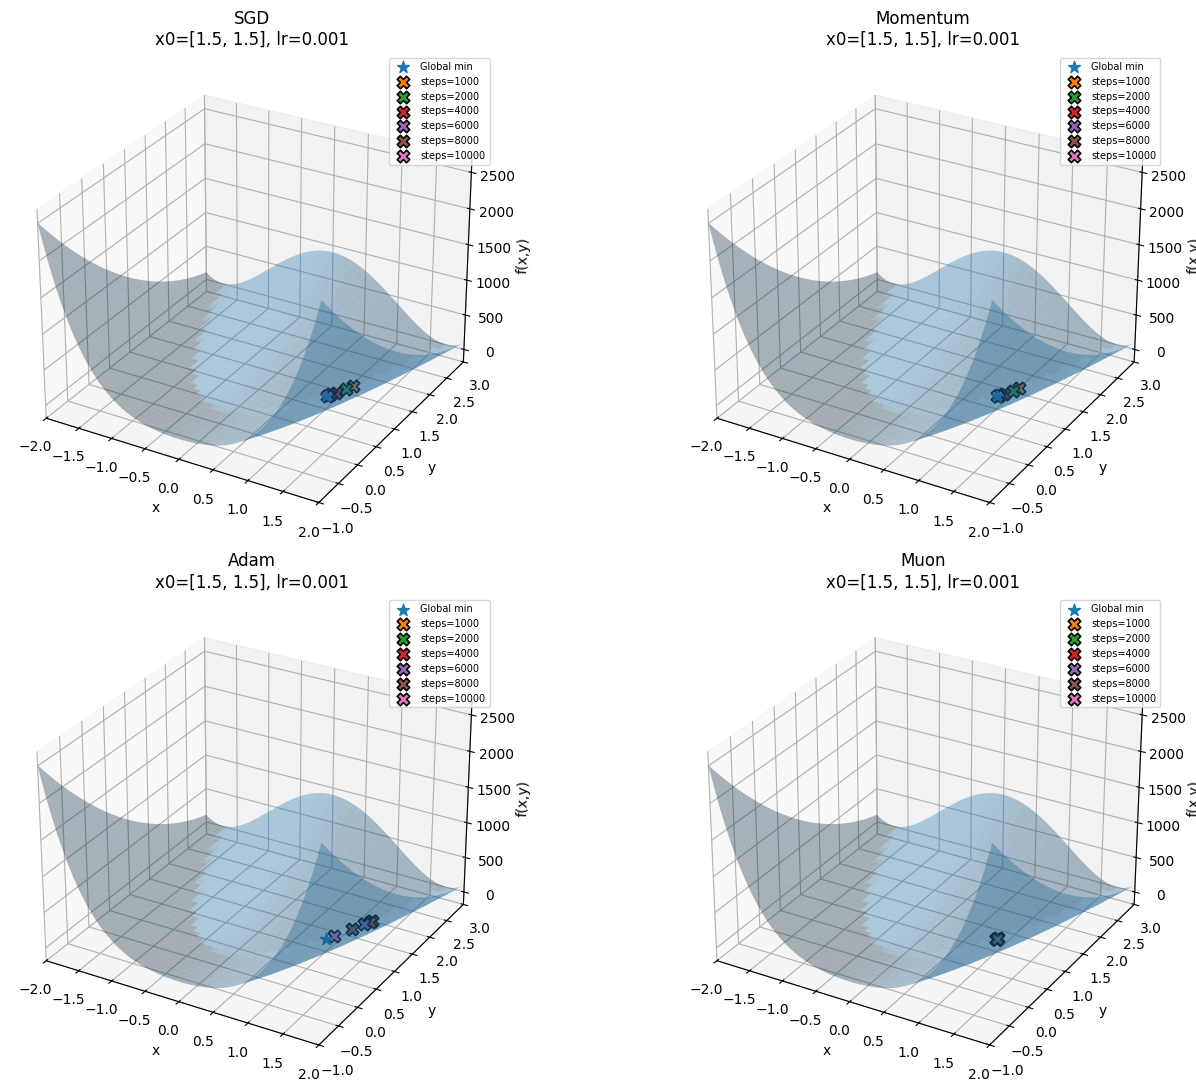


Final endpoints

Learning rate: 0.01

SGD
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   10000 |        nan        nan |          nan

Momentum
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |   1.002404   1.005368 |     0.000037
    2000 |   1.000490   1.001082 |     0.000001
    4000 |   0.990660   0.981959 |     0.000118
    6000 |   1.004974   1.009867 |     0.000026
    8000 |   0.995547   0.992032 |     0.000104
   1000

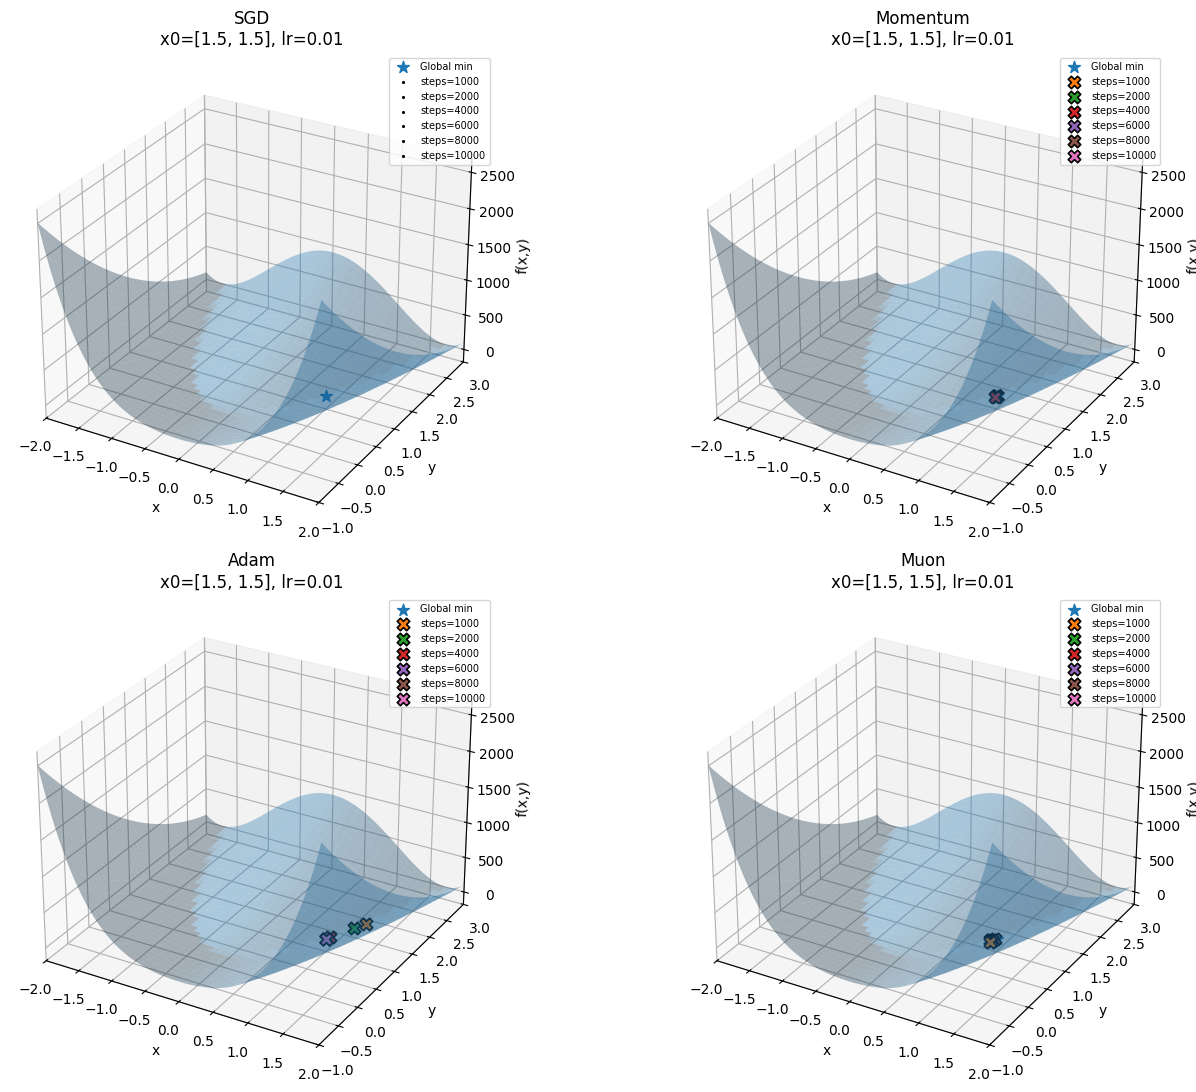


Final endpoints

Learning rate: 0.05

SGD
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   10000 |        nan        nan |          nan

Momentum
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   1000

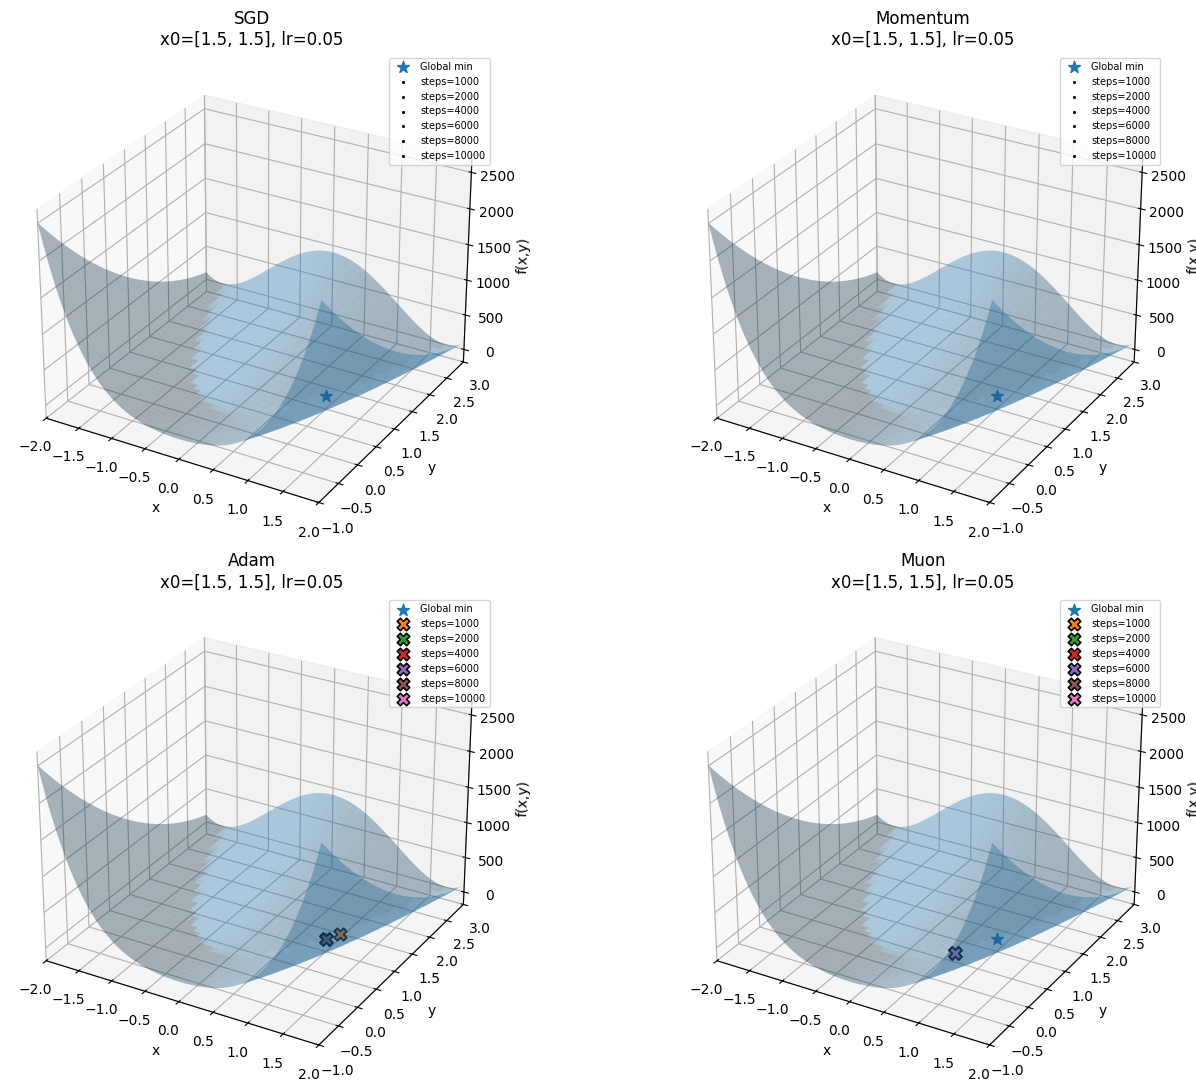


Final endpoints

Start point: [-1.5, -1.5]

Learning rate: 0.001

SGD
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |   0.687087   0.470704 |     0.098106
    2000 |   0.828906   0.686300 |     0.029335
    4000 |   0.937446   0.878810 |     0.003913
    6000 |   0.975714   0.951905 |     0.000591
    8000 |   0.992650   0.984879 |     0.000077
   10000 |   0.996706   0.994048 |     0.000050

Momentum
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |   1.180677   1.394945 |     0.032734
    2000 |   1.130405   1.278259 |     0.017025
    4000 |   1.061043   1.126209 |     0.003742
    6000 |   1.029752   1.060721 |     0.000896
    8000 |   1.011937   1.0

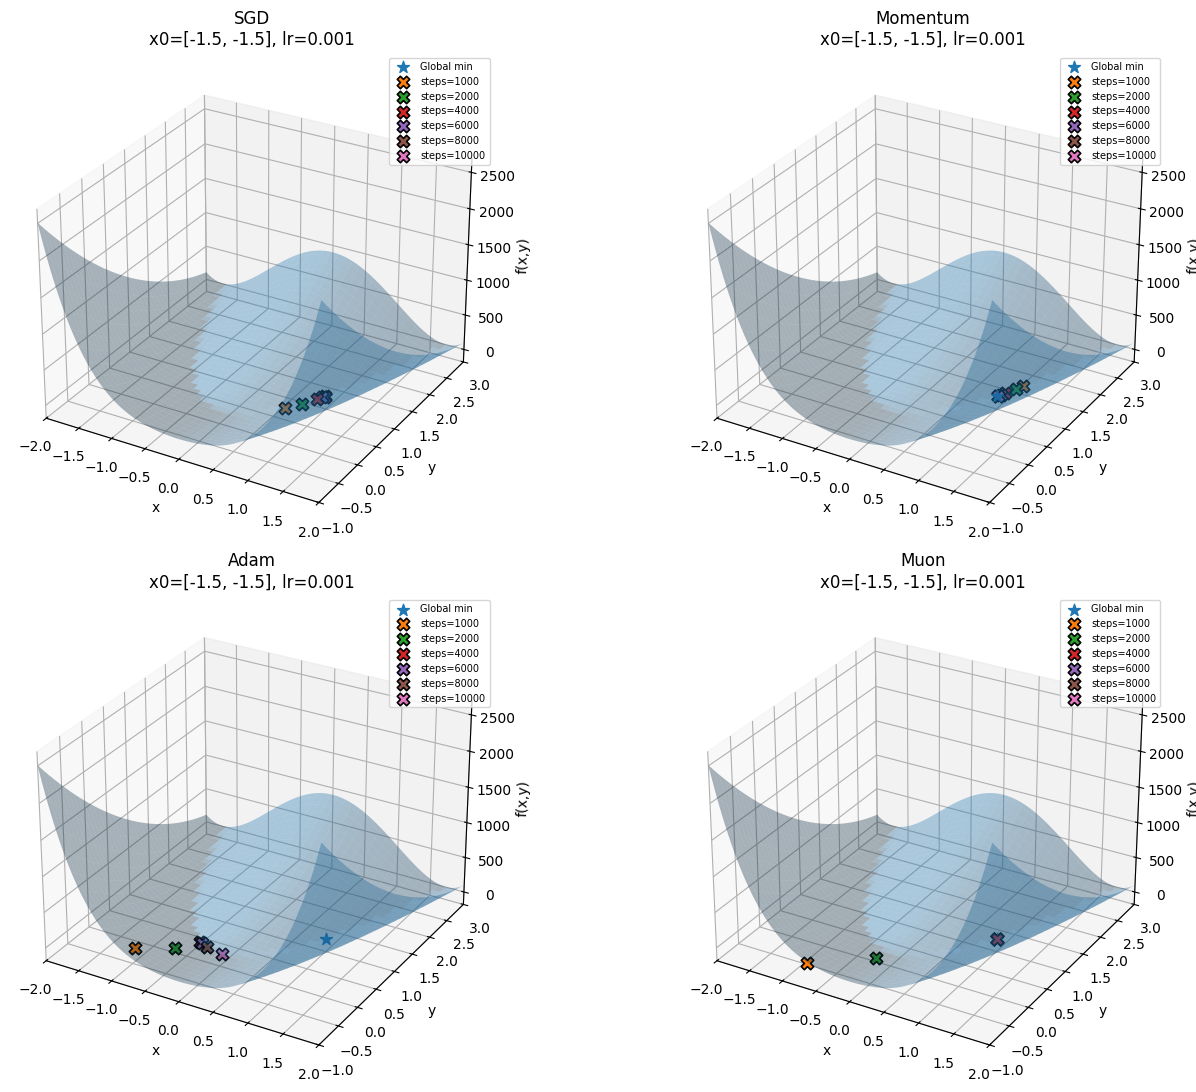


Final endpoints

Learning rate: 0.01

SGD
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   10000 |        nan        nan |          nan

Momentum
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   1000

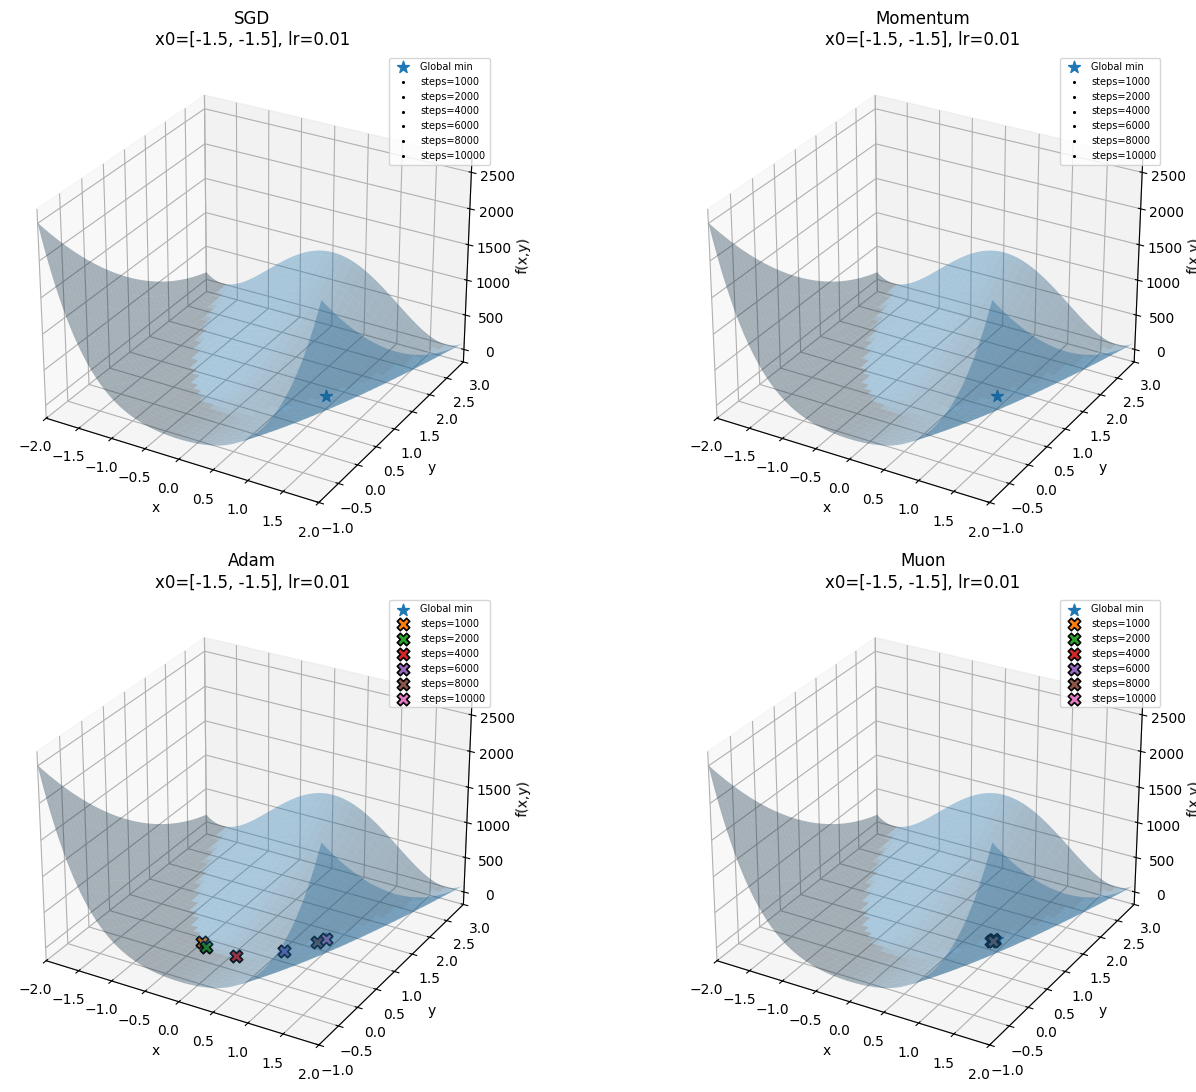


Final endpoints

Learning rate: 0.05

SGD
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   10000 |        nan        nan |          nan

Momentum
------------------------------------------------------------------------------
   steps |          x          y |       f(x,y)
------------------------------------------------------------------------------
    1000 |        nan        nan |          nan
    2000 |        nan        nan |          nan
    4000 |        nan        nan |          nan
    6000 |        nan        nan |          nan
    8000 |        nan        nan |          nan
   1000

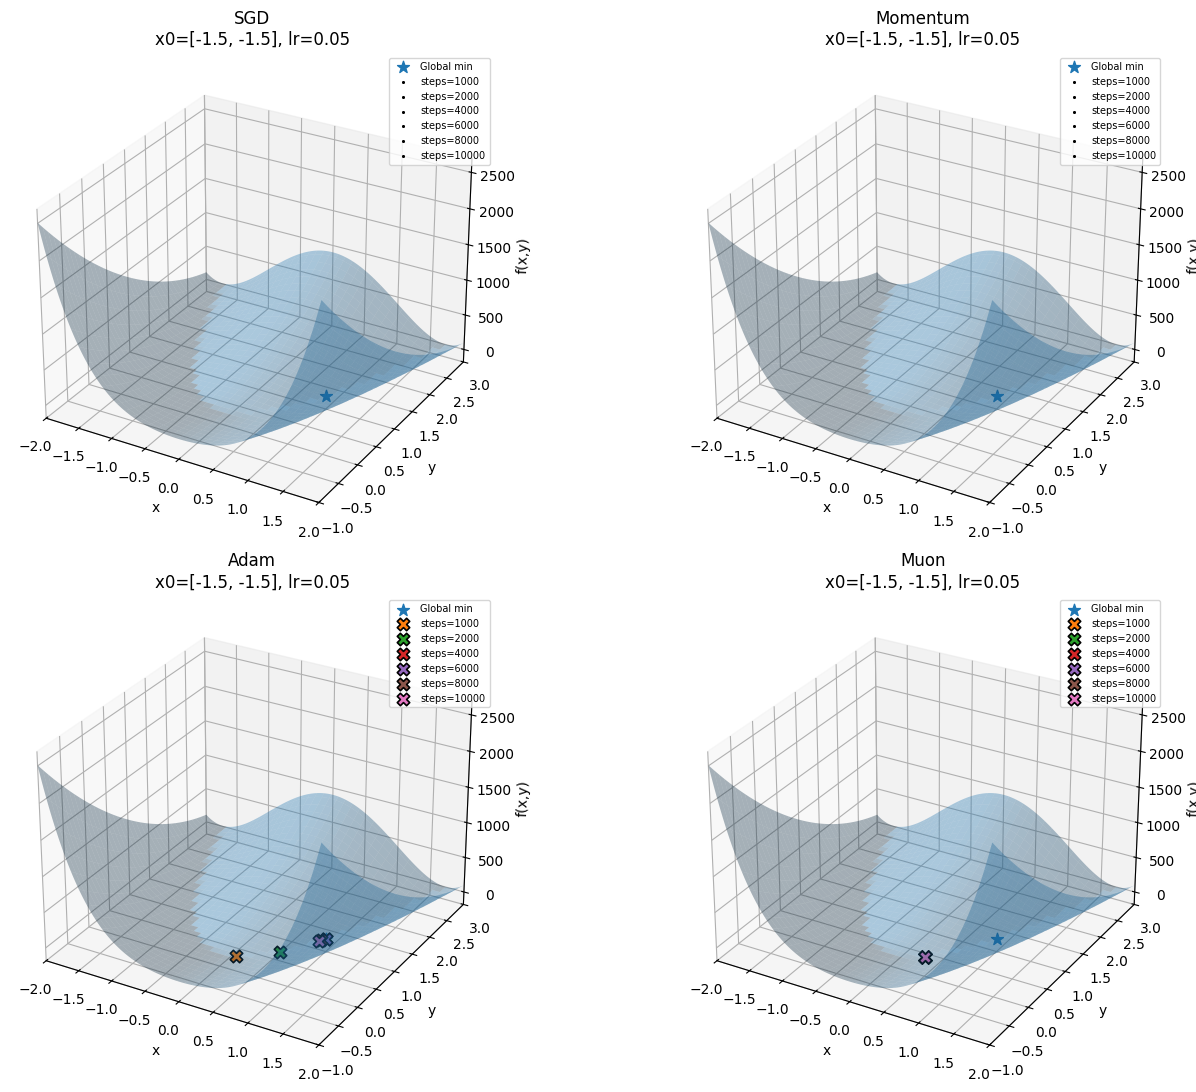


Final endpoints


In [ ]:
# Zgodnie z obliczeniami na zajęciach
domain_x=(-2.0, 2.0)
domain_y=(-1.0, 3.0)
xs = np.linspace(domain_x[0], domain_x[1], 220)
ys = np.linspace(domain_y[0], domain_y[1], 220)
X, Y = np.meshgrid(xs, ys)
Z = Z = (1 - X)**2 + 100*(Y - X**2)**2

# Obliczenia osobno dla każdego punktu startowego i learning rate
for x0 in start_points:
    print(f"\nStart point: {x0}")
    for lr in learning_rates:
        print(f"\nLearning rate: {lr}")
        results = []
        for steps in step_sizes:

            # Obliczenie wyników
            results.append(("SGD",       steps,   *optimize("SGD",       x0=x0, steps=steps, lr=lr, noise_std=0.20, seed=1),))
            results.append(("Momentum",  steps,   *optimize("Momentum",  x0=x0, steps=steps, lr=lr, noise_std=0.10, seed=2, beta=0.9)))
            results.append(("Adam",      steps,   *optimize("Adam",      x0=x0, steps=steps, lr=lr)))
            results.append(("Muon",      steps,   *optimize("Muon",      x0=x0, steps=steps, lr=lr, beta=0.9, weight_decay=1e-2)))

        # Sortowanie wyników po metodach
        by_method = defaultdict(list)
        for name, steps, x_end, f_end in results:
            by_method[name].append((steps, x_end, f_end))

        # Wypisanie w formie tekstowej wyników przedstawionych na wykresie
        for method in methods:
            rows = [(steps, x_end, f_end) for steps, x_end, f_end in by_method[method]]

            print(f"\n{method}")
            print("-" * 78)
            print(f"{'steps':>8} | {'x':>10} {'y':>10} | {'f(x,y)':>12}")
            print("-" * 78)

            for steps, x_end, f_end in rows:
                print(
                    f"{steps:8d} | "
                    f"{x_end[0]:10.6f} {x_end[1]:10.6f} | "
                    f"{f_end:12.6f}"
                )

        # Stworzenie i wizualizacja wykresu - rosenbrock z zaznaczonym minimum i x_end dla kolejnych step size
        fig = plt.figure(figsize=(15, 11))
        for i, method in enumerate(methods, 1):
            ax = fig.add_subplot(2, 2, i, projection="3d")

            # Rosenbrock
            ax.plot_surface(
                X, Y, Z,
                rstride=6, cstride=6,
                linewidth=0,
                antialiased=True,
                alpha=0.35
            )

            # Zaznaczenie minimum globalnego (funkcja Rosenbrocka ma minimum globalne w punkcie [1, 1])
            ax.scatter(1.0, 1.0, 0.0, s=80, marker="*", label="Global min", )

            # Zaznaczenie wyników w zależności od step size
            for steps, x_end, f_end in by_method[method]:
                ax.scatter(
                    x_end[0], x_end[1], f_end,
                    s=80, 
                    marker="X",
                    depthshade=False,
                    edgecolor="k",
                    linewidth=1.2,
                    label=f"steps={steps}"
                )

            ax.set_title(f"{method}\nx0={x0}, lr={lr}")
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("f(x,y)")
            ax.set_xlim(domain_x)
            ax.set_ylim(domain_y)
            ax.view_init(elev=28, azim=-60)
            ax.legend(fontsize=7)

        plt.tight_layout()
        plt.show()
        
        print("\nFinal endpoints")
        print("=" * 78)


## Wnioski

### SGD
- bardzo wrażliwy na learning rate, przy lr = 0.01 lub 0.05 --> dostaliśmy NaN
- zbieżoność była stosunkowo powolna w porównaniu do innych metod (gdy działała przy odpowiednim learning rate)

### Momentum
- również metoda wrażliwa na learning rate, ale było stabilniej niż przy SGD
- przy punkcie startowym [-1.5, -1.5] nie poradziła sobie przy lr = 0.01, mimo że dla innego punktu starowego zadziałała prawidłowo
- ogólnie zbiegała się trochę szybciej niż SGD, ale wydaje się bardzo zależna od wybranego punktu startowego (co ma sens, bo z tego co pamiętam była to metoda która wykorzystuje ten rozpęd z poprzednich iteracji i jeśli jest dobry - szybko znajdzie minimum, jeśli nie ...)

### Adam
- radził sobie dobrze niezależnie od wybranego learning rate
- czasami większa ilość kroków prowadziła do pogorszenia wyniku
- ogólnie tak całościowo radził sobie najelpiej ze wszystkich metod, ale miał swoje dziwne momenty (start w [-1.5 ,-1.5] dla lr=0.001 --> tak chodził po wykresie i skończył w ok ale dziwnym miejscu z f ~ 0.9)

### Muon
- dobrze sobie radził przy małym learning rate
- tak jak Adam - odporny na stosowanie różżnych learning rate w tym sensie że nie zwracał NaN, ale było widać że przy większym lr zaczął utykać w dziwnych miejscach (to chyba lokalne minima?)


### Ogólne wnioski
- SGD i Momentum nie radziły sobie z wysokim learning rate, co ogólnie pokazuje też jak bardzo diametralnie dobór złego learning rate może uniemożliwić nam uzyskanie sensownych wyników
- Adam okazał się stosunkowo odporny na zmiany w learning rate, był ogólnie najstabilniejszzą metodą
- wybór punktu startowego ma znaczenia - wszystkie metody radziły sobie o wiele lepiej przy początku w punkcie [1.5, 1.5] niż [-1.5, -1.5]